In [1]:
from qiskit.utils import algorithm_globals
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torch import nn
from torch.optim import Adam
import torch, time, argparse, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,10)

In [3]:
nx = 4

xmin, xmax = 40., 168.
dx = (xmax-xmin)/(2**nx)

In [4]:
rseed = int(datetime.now().timestamp())

algorithm_globals.random_seed = rseed
_ = torch.manual_seed(rseed) 

In [5]:
num_dim = 1
num_discrete_values = 2**nx
n = num_dim * int(np.log2(num_discrete_values))

In [6]:
coords = np.linspace(-2, 2, num_discrete_values)
grid_elements = np.expand_dims(coords,axis=1)
xs = np.arange(xmin, xmax, dx)
prob_data = xs**(-7./3)
prob_data = prob_data / np.sum(prob_data)

In [7]:
shots=10000

sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

In [8]:
qc = QuantumCircuit(n)
qc.h(qc.qubits);

In [9]:
reps = 12

ansatz = RealAmplitudes(n, reps=reps)
qc.compose(ansatz, inplace=True)

In [10]:
def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)    

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [11]:
generator = create_generator()
discriminator = Discriminator(num_dim)

In [12]:
lr=0.01
b1=0.7
b2=0.999

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

In [13]:
generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

n_epochs=2000

num_qnn_outputs = num_discrete_values**num_dim

n_epochs = n_epochs-len(entropy_values)
        
start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    with torch.no_grad():
        generated_weights = generator.weight.detach().numpy().reshape((reps+1,n))
        
    circ = QuantumCircuit(n)
    circ.h(circ.qubits)

    for rep in np.arange(reps+1):
        for i in np.arange(n):
            circ.ry(generated_weights[rep,i],circ.qubits[i])
        for i in np.arange(n):
            if i!=n-1 and rep!=reps:
                circ.cx(circ.qubits[i], circ.qubits[i+1])
        
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    state_vector = np.asarray(result.get_statevector())
        
    entropy_value = 1-np.sqrt(np.abs(np.dot(np.sqrt(prob_data),np.conjugate(state_vector)))**2)
    entropy_values.append(entropy_value)
        
    print(np.round(100.*(epoch/n_epochs),2),'%','Mismatch:',"{:.2e}".format(entropy_value),'Generator loss:', np.round(generator_loss_values[-1],2), 'Discriminator loss:', np.round(discriminator_loss_values[-1],2))
    sys.stdout.write("\033[F")
    
print(np.round(100.*(epoch/n_epochs),2),'%','Mismatch:',"{:.2e}".format(entropy_value),'Generator loss:', np.round(generator_loss_values[-1],2), 'Discriminator loss:', np.round(discriminator_loss_values[-1],2))

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

0.0 % Mismatch: 8.45e-01 Generator loss: 0.83 Discriminator loss: 0.59
0.05 % Mismatch: 8.35e-01 Generator loss: 0.82 Discriminator loss: 0.57
0.1 % Mismatch: 8.20e-01 Generator loss: 0.82 Discriminator loss: 0.57
0.15 % Mismatch: 8.02e-01 Generator loss: 0.81 Discriminator loss: 0.57
0.2 % Mismatch: 7.81e-01 Generator loss: 0.8 Discriminator loss: 0.57
0.25 % Mismatch: 7.56e-01 Generator loss: 0.79 Discriminator loss: 0.58
0.3 % Mismatch: 7.29e-01 Generator loss: 0.78 Discriminator loss: 0.6
0.35 % Mismatch: 7.00e-01 Generator loss: 0.76 Discriminator loss: 0.62
0.4 % Mismatch: 6.73e-01 Generator loss: 0.75 Discriminator loss: 0.64
0.45 % Mismatch: 6.46e-01 Generator loss: 0.74 Discriminator loss: 0.66
0.5 % Mismatch: 6.20e-01 Generator loss: 0.73 Discriminator loss: 0.68
0.55 % Mismatch: 5.96e-01 Generator loss: 0.72 Discriminator loss: 0.7
0.6 % Mismatch: 5.75e-01 Generator loss: 0.73 Discriminator loss: 0.71
0.65 % Mismatch: 5.58e-01 Generator loss: 0.74 Discriminator loss: 0.71
0.

5.55 % Mismatch: 7.26e-01 Generator loss: 0.65 Discriminator loss: 0.7
5.6 % Mismatch: 7.30e-01 Generator loss: 0.65 Discriminator loss: 0.69
5.65 % Mismatch: 7.32e-01 Generator loss: 0.64 Discriminator loss: 0.69
5.7 % Mismatch: 7.33e-01 Generator loss: 0.64 Discriminator loss: 0.69
5.75 % Mismatch: 7.32e-01 Generator loss: 0.64 Discriminator loss: 0.69
5.8 % Mismatch: 7.30e-01 Generator loss: 0.64 Discriminator loss: 0.69
5.85 % Mismatch: 7.27e-01 Generator loss: 0.63 Discriminator loss: 0.69
5.9 % Mismatch: 7.22e-01 Generator loss: 0.63 Discriminator loss: 0.69
5.95 % Mismatch: 7.17e-01 Generator loss: 0.63 Discriminator loss: 0.69
6.0 % Mismatch: 7.11e-01 Generator loss: 0.63 Discriminator loss: 0.69
6.05 % Mismatch: 7.04e-01 Generator loss: 0.63 Discriminator loss: 0.69
6.1 % Mismatch: 6.96e-01 Generator loss: 0.64 Discriminator loss: 0.69
6.15 % Mismatch: 6.89e-01 Generator loss: 0.64 Discriminator loss: 0.69
6.2 % Mismatch: 6.82e-01 Generator loss: 0.64 Discriminator loss: 0.69


11.1 % Mismatch: 7.11e-01 Generator loss: 0.69 Discriminator loss: 0.69
11.15 % Mismatch: 7.15e-01 Generator loss: 0.69 Discriminator loss: 0.69
11.2 % Mismatch: 7.19e-01 Generator loss: 0.69 Discriminator loss: 0.69
11.25 % Mismatch: 7.23e-01 Generator loss: 0.68 Discriminator loss: 0.69
11.3 % Mismatch: 7.27e-01 Generator loss: 0.68 Discriminator loss: 0.69
11.35 % Mismatch: 7.30e-01 Generator loss: 0.68 Discriminator loss: 0.69
11.4 % Mismatch: 7.33e-01 Generator loss: 0.68 Discriminator loss: 0.69
11.45 % Mismatch: 7.36e-01 Generator loss: 0.68 Discriminator loss: 0.69
11.5 % Mismatch: 7.38e-01 Generator loss: 0.67 Discriminator loss: 0.69
11.55 % Mismatch: 7.40e-01 Generator loss: 0.67 Discriminator loss: 0.69
11.6 % Mismatch: 7.42e-01 Generator loss: 0.67 Discriminator loss: 0.69
11.65 % Mismatch: 7.43e-01 Generator loss: 0.67 Discriminator loss: 0.69
11.7 % Mismatch: 7.44e-01 Generator loss: 0.67 Discriminator loss: 0.69
11.75 % Mismatch: 7.45e-01 Generator loss: 0.67 Discrimina

16.55 % Mismatch: 7.73e-01 Generator loss: 0.69 Discriminator loss: 0.69
16.6 % Mismatch: 7.72e-01 Generator loss: 0.7 Discriminator loss: 0.69
16.65 % Mismatch: 7.72e-01 Generator loss: 0.7 Discriminator loss: 0.69
16.7 % Mismatch: 7.71e-01 Generator loss: 0.7 Discriminator loss: 0.69
16.75 % Mismatch: 7.70e-01 Generator loss: 0.69 Discriminator loss: 0.69
16.8 % Mismatch: 7.68e-01 Generator loss: 0.69 Discriminator loss: 0.69
16.85 % Mismatch: 7.67e-01 Generator loss: 0.69 Discriminator loss: 0.69
16.9 % Mismatch: 7.65e-01 Generator loss: 0.69 Discriminator loss: 0.69
16.95 % Mismatch: 7.64e-01 Generator loss: 0.7 Discriminator loss: 0.69
17.0 % Mismatch: 7.63e-01 Generator loss: 0.7 Discriminator loss: 0.69
17.05 % Mismatch: 7.61e-01 Generator loss: 0.7 Discriminator loss: 0.69
17.1 % Mismatch: 7.60e-01 Generator loss: 0.7 Discriminator loss: 0.69
17.15 % Mismatch: 7.59e-01 Generator loss: 0.69 Discriminator loss: 0.69
17.2 % Mismatch: 7.57e-01 Generator loss: 0.69 Discriminator los

22.05 % Mismatch: 8.38e-01 Generator loss: 0.69 Discriminator loss: 0.69
22.1 % Mismatch: 8.40e-01 Generator loss: 0.69 Discriminator loss: 0.69
22.15 % Mismatch: 8.41e-01 Generator loss: 0.68 Discriminator loss: 0.69
22.2 % Mismatch: 8.42e-01 Generator loss: 0.68 Discriminator loss: 0.69
22.25 % Mismatch: 8.42e-01 Generator loss: 0.68 Discriminator loss: 0.69
22.3 % Mismatch: 8.41e-01 Generator loss: 0.68 Discriminator loss: 0.69
22.35 % Mismatch: 8.40e-01 Generator loss: 0.68 Discriminator loss: 0.69
22.4 % Mismatch: 8.38e-01 Generator loss: 0.67 Discriminator loss: 0.69
22.45 % Mismatch: 8.35e-01 Generator loss: 0.67 Discriminator loss: 0.69
22.5 % Mismatch: 8.30e-01 Generator loss: 0.67 Discriminator loss: 0.69
22.55 % Mismatch: 8.26e-01 Generator loss: 0.66 Discriminator loss: 0.69
22.6 % Mismatch: 8.21e-01 Generator loss: 0.66 Discriminator loss: 0.69
22.65 % Mismatch: 8.16e-01 Generator loss: 0.67 Discriminator loss: 0.69
22.7 % Mismatch: 8.11e-01 Generator loss: 0.67 Discrimina

27.5 % Mismatch: 8.71e-01 Generator loss: 0.66 Discriminator loss: 0.69
27.55 % Mismatch: 8.49e-01 Generator loss: 0.65 Discriminator loss: 0.69
27.6 % Mismatch: 8.26e-01 Generator loss: 0.64 Discriminator loss: 0.69
27.65 % Mismatch: 8.06e-01 Generator loss: 0.64 Discriminator loss: 0.7
27.7 % Mismatch: 7.91e-01 Generator loss: 0.64 Discriminator loss: 0.7
27.75 % Mismatch: 7.81e-01 Generator loss: 0.66 Discriminator loss: 0.7
27.8 % Mismatch: 7.75e-01 Generator loss: 0.67 Discriminator loss: 0.7
27.85 % Mismatch: 7.72e-01 Generator loss: 0.7 Discriminator loss: 0.7
27.9 % Mismatch: 7.71e-01 Generator loss: 0.72 Discriminator loss: 0.7
27.95 % Mismatch: 7.71e-01 Generator loss: 0.74 Discriminator loss: 0.7
28.0 % Mismatch: 7.71e-01 Generator loss: 0.75 Discriminator loss: 0.7
28.05 % Mismatch: 7.72e-01 Generator loss: 0.75 Discriminator loss: 0.7
28.1 % Mismatch: 7.72e-01 Generator loss: 0.75 Discriminator loss: 0.7
28.15 % Mismatch: 7.73e-01 Generator loss: 0.74 Discriminator loss: 0

33.0 % Mismatch: 8.84e-01 Generator loss: 0.69 Discriminator loss: 0.7
33.05 % Mismatch: 8.99e-01 Generator loss: 0.68 Discriminator loss: 0.7
33.1 % Mismatch: 9.15e-01 Generator loss: 0.68 Discriminator loss: 0.7
33.15 % Mismatch: 9.29e-01 Generator loss: 0.68 Discriminator loss: 0.7
33.2 % Mismatch: 9.41e-01 Generator loss: 0.68 Discriminator loss: 0.69
33.25 % Mismatch: 9.51e-01 Generator loss: 0.68 Discriminator loss: 0.69
33.3 % Mismatch: 9.58e-01 Generator loss: 0.68 Discriminator loss: 0.69
33.35 % Mismatch: 9.62e-01 Generator loss: 0.68 Discriminator loss: 0.69
33.4 % Mismatch: 9.63e-01 Generator loss: 0.68 Discriminator loss: 0.69
33.45 % Mismatch: 9.60e-01 Generator loss: 0.68 Discriminator loss: 0.69
33.5 % Mismatch: 9.52e-01 Generator loss: 0.68 Discriminator loss: 0.68
33.55 % Mismatch: 9.38e-01 Generator loss: 0.67 Discriminator loss: 0.68
33.6 % Mismatch: 9.17e-01 Generator loss: 0.66 Discriminator loss: 0.68
33.65 % Mismatch: 8.88e-01 Generator loss: 0.65 Discriminator 

38.45 % Mismatch: 7.16e-01 Generator loss: 0.7 Discriminator loss: 0.69
38.5 % Mismatch: 7.15e-01 Generator loss: 0.69 Discriminator loss: 0.69
38.55 % Mismatch: 7.14e-01 Generator loss: 0.69 Discriminator loss: 0.69
38.6 % Mismatch: 7.14e-01 Generator loss: 0.69 Discriminator loss: 0.69
38.65 % Mismatch: 7.14e-01 Generator loss: 0.69 Discriminator loss: 0.69
38.7 % Mismatch: 7.13e-01 Generator loss: 0.69 Discriminator loss: 0.69
38.75 % Mismatch: 7.13e-01 Generator loss: 0.69 Discriminator loss: 0.69
38.8 % Mismatch: 7.13e-01 Generator loss: 0.69 Discriminator loss: 0.69
38.85 % Mismatch: 7.13e-01 Generator loss: 0.69 Discriminator loss: 0.69
38.9 % Mismatch: 7.13e-01 Generator loss: 0.69 Discriminator loss: 0.69
38.95 % Mismatch: 7.13e-01 Generator loss: 0.69 Discriminator loss: 0.69
39.0 % Mismatch: 7.13e-01 Generator loss: 0.69 Discriminator loss: 0.69
39.05 % Mismatch: 7.13e-01 Generator loss: 0.69 Discriminator loss: 0.69
39.1 % Mismatch: 7.13e-01 Generator loss: 0.69 Discriminat

43.9 % Mismatch: 7.32e-01 Generator loss: 0.63 Discriminator loss: 0.7
43.95 % Mismatch: 7.48e-01 Generator loss: 0.63 Discriminator loss: 0.7
44.0 % Mismatch: 7.61e-01 Generator loss: 0.63 Discriminator loss: 0.7
44.05 % Mismatch: 7.70e-01 Generator loss: 0.63 Discriminator loss: 0.69
44.1 % Mismatch: 7.76e-01 Generator loss: 0.63 Discriminator loss: 0.69
44.15 % Mismatch: 7.79e-01 Generator loss: 0.63 Discriminator loss: 0.69
44.2 % Mismatch: 7.77e-01 Generator loss: 0.63 Discriminator loss: 0.69
44.25 % Mismatch: 7.72e-01 Generator loss: 0.64 Discriminator loss: 0.69
44.3 % Mismatch: 7.62e-01 Generator loss: 0.64 Discriminator loss: 0.68
44.35 % Mismatch: 7.45e-01 Generator loss: 0.64 Discriminator loss: 0.68
44.4 % Mismatch: 7.21e-01 Generator loss: 0.64 Discriminator loss: 0.68
44.45 % Mismatch: 6.89e-01 Generator loss: 0.64 Discriminator loss: 0.68
44.5 % Mismatch: 6.51e-01 Generator loss: 0.64 Discriminator loss: 0.68
44.55 % Mismatch: 6.10e-01 Generator loss: 0.63 Discriminator

49.4 % Mismatch: 9.82e-01 Generator loss: 0.72 Discriminator loss: 0.62
49.45 % Mismatch: 9.70e-01 Generator loss: 0.71 Discriminator loss: 0.6
49.5 % Mismatch: 8.96e-01 Generator loss: 0.68 Discriminator loss: 0.6
49.55 % Mismatch: 7.97e-01 Generator loss: 0.61 Discriminator loss: 0.63
49.6 % Mismatch: 7.06e-01 Generator loss: 0.51 Discriminator loss: 0.72
49.65 % Mismatch: 6.62e-01 Generator loss: 0.41 Discriminator loss: 0.8
49.7 % Mismatch: 6.61e-01 Generator loss: 0.42 Discriminator loss: 0.8
49.75 % Mismatch: 6.79e-01 Generator loss: 0.5 Discriminator loss: 0.76
49.8 % Mismatch: 7.00e-01 Generator loss: 0.6 Discriminator loss: 0.73
49.85 % Mismatch: 7.23e-01 Generator loss: 0.67 Discriminator loss: 0.72
49.9 % Mismatch: 7.47e-01 Generator loss: 0.73 Discriminator loss: 0.72
49.95 % Mismatch: 7.70e-01 Generator loss: 0.77 Discriminator loss: 0.72
50.0 % Mismatch: 7.91e-01 Generator loss: 0.8 Discriminator loss: 0.72
50.05 % Mismatch: 8.08e-01 Generator loss: 0.81 Discriminator los

54.85 % Mismatch: 4.04e-01 Generator loss: 0.64 Discriminator loss: 0.7
54.9 % Mismatch: 4.07e-01 Generator loss: 0.64 Discriminator loss: 0.7
54.95 % Mismatch: 4.08e-01 Generator loss: 0.65 Discriminator loss: 0.69
55.0 % Mismatch: 4.09e-01 Generator loss: 0.65 Discriminator loss: 0.69
55.05 % Mismatch: 4.08e-01 Generator loss: 0.66 Discriminator loss: 0.69
55.1 % Mismatch: 4.06e-01 Generator loss: 0.66 Discriminator loss: 0.69
55.15 % Mismatch: 4.02e-01 Generator loss: 0.67 Discriminator loss: 0.69
55.2 % Mismatch: 3.97e-01 Generator loss: 0.68 Discriminator loss: 0.68
55.25 % Mismatch: 3.89e-01 Generator loss: 0.69 Discriminator loss: 0.68
55.3 % Mismatch: 3.77e-01 Generator loss: 0.7 Discriminator loss: 0.67
55.35 % Mismatch: 3.62e-01 Generator loss: 0.72 Discriminator loss: 0.67
55.4 % Mismatch: 3.45e-01 Generator loss: 0.74 Discriminator loss: 0.66
55.45 % Mismatch: 3.25e-01 Generator loss: 0.75 Discriminator loss: 0.66
55.5 % Mismatch: 3.07e-01 Generator loss: 0.76 Discriminator

60.3 % Mismatch: 3.05e-01 Generator loss: 0.66 Discriminator loss: 0.71
60.35 % Mismatch: 3.25e-01 Generator loss: 0.7 Discriminator loss: 0.7
60.4 % Mismatch: 3.43e-01 Generator loss: 0.73 Discriminator loss: 0.7
60.45 % Mismatch: 3.57e-01 Generator loss: 0.75 Discriminator loss: 0.7
60.5 % Mismatch: 3.68e-01 Generator loss: 0.76 Discriminator loss: 0.7
60.55 % Mismatch: 3.75e-01 Generator loss: 0.76 Discriminator loss: 0.7
60.6 % Mismatch: 3.79e-01 Generator loss: 0.76 Discriminator loss: 0.7
60.65 % Mismatch: 3.81e-01 Generator loss: 0.76 Discriminator loss: 0.69
60.7 % Mismatch: 3.81e-01 Generator loss: 0.75 Discriminator loss: 0.69
60.75 % Mismatch: 3.80e-01 Generator loss: 0.75 Discriminator loss: 0.69
60.8 % Mismatch: 3.78e-01 Generator loss: 0.75 Discriminator loss: 0.69
60.85 % Mismatch: 3.75e-01 Generator loss: 0.75 Discriminator loss: 0.69
60.9 % Mismatch: 3.71e-01 Generator loss: 0.76 Discriminator loss: 0.69
60.95 % Mismatch: 3.67e-01 Generator loss: 0.77 Discriminator los

65.75 % Mismatch: 5.06e-01 Generator loss: 0.76 Discriminator loss: 0.69
65.8 % Mismatch: 5.04e-01 Generator loss: 0.76 Discriminator loss: 0.69
65.85 % Mismatch: 5.03e-01 Generator loss: 0.76 Discriminator loss: 0.69
65.9 % Mismatch: 5.01e-01 Generator loss: 0.76 Discriminator loss: 0.69
65.95 % Mismatch: 5.00e-01 Generator loss: 0.76 Discriminator loss: 0.68
66.0 % Mismatch: 5.00e-01 Generator loss: 0.77 Discriminator loss: 0.68
66.05 % Mismatch: 5.00e-01 Generator loss: 0.77 Discriminator loss: 0.68
66.1 % Mismatch: 5.00e-01 Generator loss: 0.77 Discriminator loss: 0.68
66.15 % Mismatch: 5.01e-01 Generator loss: 0.77 Discriminator loss: 0.68
66.2 % Mismatch: 5.02e-01 Generator loss: 0.78 Discriminator loss: 0.67
66.25 % Mismatch: 5.04e-01 Generator loss: 0.78 Discriminator loss: 0.67
66.3 % Mismatch: 5.05e-01 Generator loss: 0.78 Discriminator loss: 0.67
66.35 % Mismatch: 5.06e-01 Generator loss: 0.77 Discriminator loss: 0.67
66.4 % Mismatch: 5.08e-01 Generator loss: 0.75 Discrimina

71.25 % Mismatch: 7.11e-01 Generator loss: 0.76 Discriminator loss: 0.69
71.3 % Mismatch: 7.15e-01 Generator loss: 0.75 Discriminator loss: 0.69
71.35 % Mismatch: 7.19e-01 Generator loss: 0.75 Discriminator loss: 0.69
71.4 % Mismatch: 7.23e-01 Generator loss: 0.75 Discriminator loss: 0.69
71.45 % Mismatch: 7.26e-01 Generator loss: 0.74 Discriminator loss: 0.69
71.5 % Mismatch: 7.30e-01 Generator loss: 0.74 Discriminator loss: 0.69
71.55 % Mismatch: 7.35e-01 Generator loss: 0.74 Discriminator loss: 0.69
71.6 % Mismatch: 7.39e-01 Generator loss: 0.74 Discriminator loss: 0.69
71.65 % Mismatch: 7.43e-01 Generator loss: 0.74 Discriminator loss: 0.69
71.7 % Mismatch: 7.48e-01 Generator loss: 0.74 Discriminator loss: 0.69
71.75 % Mismatch: 7.53e-01 Generator loss: 0.74 Discriminator loss: 0.69
71.8 % Mismatch: 7.58e-01 Generator loss: 0.74 Discriminator loss: 0.69
71.85 % Mismatch: 7.63e-01 Generator loss: 0.74 Discriminator loss: 0.69
71.9 % Mismatch: 7.69e-01 Generator loss: 0.74 Discrimina

76.7 % Mismatch: 7.28e-01 Generator loss: 0.68 Discriminator loss: 0.69
76.75 % Mismatch: 7.30e-01 Generator loss: 0.69 Discriminator loss: 0.68
76.8 % Mismatch: 7.35e-01 Generator loss: 0.69 Discriminator loss: 0.68
76.85 % Mismatch: 7.44e-01 Generator loss: 0.7 Discriminator loss: 0.68
76.9 % Mismatch: 7.60e-01 Generator loss: 0.7 Discriminator loss: 0.67
76.95 % Mismatch: 7.86e-01 Generator loss: 0.7 Discriminator loss: 0.67
77.0 % Mismatch: 8.24e-01 Generator loss: 0.69 Discriminator loss: 0.68
77.05 % Mismatch: 8.76e-01 Generator loss: 0.68 Discriminator loss: 0.68
77.1 % Mismatch: 9.39e-01 Generator loss: 0.66 Discriminator loss: 0.69
77.15 % Mismatch: 9.93e-01 Generator loss: 0.65 Discriminator loss: 0.69
77.2 % Mismatch: 9.26e-01 Generator loss: 0.64 Discriminator loss: 0.7
77.25 % Mismatch: 8.62e-01 Generator loss: 0.64 Discriminator loss: 0.7
77.3 % Mismatch: 8.05e-01 Generator loss: 0.64 Discriminator loss: 0.7
77.35 % Mismatch: 7.53e-01 Generator loss: 0.64 Discriminator lo

82.2 % Mismatch: 7.77e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.25 % Mismatch: 7.83e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.3 % Mismatch: 7.90e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.35 % Mismatch: 7.97e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.4 % Mismatch: 8.04e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.45 % Mismatch: 8.12e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.5 % Mismatch: 8.19e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.55 % Mismatch: 8.27e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.6 % Mismatch: 8.36e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.65 % Mismatch: 8.44e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.7 % Mismatch: 8.53e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.75 % Mismatch: 8.63e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.8 % Mismatch: 8.74e-01 Generator loss: 0.7 Discriminator loss: 0.69
82.85 % Mismatch: 8.85e-01 Generator loss: 0.7 Discriminator loss: 0.69

87.7 % Mismatch: 7.81e-01 Generator loss: 0.64 Discriminator loss: 0.68
87.75 % Mismatch: 7.73e-01 Generator loss: 0.64 Discriminator loss: 0.68
87.8 % Mismatch: 7.64e-01 Generator loss: 0.64 Discriminator loss: 0.68
87.85 % Mismatch: 7.53e-01 Generator loss: 0.64 Discriminator loss: 0.67
87.9 % Mismatch: 7.42e-01 Generator loss: 0.63 Discriminator loss: 0.67
87.95 % Mismatch: 7.30e-01 Generator loss: 0.61 Discriminator loss: 0.67
88.0 % Mismatch: 7.19e-01 Generator loss: 0.6 Discriminator loss: 0.67
88.05 % Mismatch: 7.10e-01 Generator loss: 0.58 Discriminator loss: 0.67
88.1 % Mismatch: 7.04e-01 Generator loss: 0.57 Discriminator loss: 0.68
88.15 % Mismatch: 7.04e-01 Generator loss: 0.58 Discriminator loss: 0.69
88.2 % Mismatch: 7.11e-01 Generator loss: 0.6 Discriminator loss: 0.69
88.25 % Mismatch: 7.24e-01 Generator loss: 0.63 Discriminator loss: 0.7
88.3 % Mismatch: 7.42e-01 Generator loss: 0.66 Discriminator loss: 0.7
88.35 % Mismatch: 7.64e-01 Generator loss: 0.69 Discriminator 

93.2 % Mismatch: 7.58e-01 Generator loss: 0.77 Discriminator loss: 0.7
93.25 % Mismatch: 7.56e-01 Generator loss: 0.77 Discriminator loss: 0.7
93.3 % Mismatch: 7.54e-01 Generator loss: 0.76 Discriminator loss: 0.7
93.35 % Mismatch: 7.50e-01 Generator loss: 0.76 Discriminator loss: 0.7
93.4 % Mismatch: 7.46e-01 Generator loss: 0.75 Discriminator loss: 0.7
93.45 % Mismatch: 7.42e-01 Generator loss: 0.75 Discriminator loss: 0.69
93.5 % Mismatch: 7.38e-01 Generator loss: 0.74 Discriminator loss: 0.69
93.55 % Mismatch: 7.34e-01 Generator loss: 0.74 Discriminator loss: 0.69
93.6 % Mismatch: 7.30e-01 Generator loss: 0.74 Discriminator loss: 0.69
93.65 % Mismatch: 7.25e-01 Generator loss: 0.73 Discriminator loss: 0.69
93.7 % Mismatch: 7.21e-01 Generator loss: 0.73 Discriminator loss: 0.69
93.75 % Mismatch: 7.16e-01 Generator loss: 0.72 Discriminator loss: 0.69
93.8 % Mismatch: 7.12e-01 Generator loss: 0.72 Discriminator loss: 0.69
93.85 % Mismatch: 7.07e-01 Generator loss: 0.72 Discriminator l

98.65 % Mismatch: 2.72e-01 Generator loss: 0.68 Discriminator loss: 0.69
98.7 % Mismatch: 2.67e-01 Generator loss: 0.68 Discriminator loss: 0.69
98.75 % Mismatch: 2.63e-01 Generator loss: 0.68 Discriminator loss: 0.69
98.8 % Mismatch: 2.58e-01 Generator loss: 0.68 Discriminator loss: 0.69
98.85 % Mismatch: 2.54e-01 Generator loss: 0.68 Discriminator loss: 0.69
98.9 % Mismatch: 2.51e-01 Generator loss: 0.68 Discriminator loss: 0.69
98.95 % Mismatch: 2.48e-01 Generator loss: 0.68 Discriminator loss: 0.69
99.0 % Mismatch: 2.46e-01 Generator loss: 0.69 Discriminator loss: 0.69
99.05 % Mismatch: 2.45e-01 Generator loss: 0.69 Discriminator loss: 0.7
99.1 % Mismatch: 2.43e-01 Generator loss: 0.69 Discriminator loss: 0.7
99.15 % Mismatch: 2.42e-01 Generator loss: 0.7 Discriminator loss: 0.69
99.2 % Mismatch: 2.42e-01 Generator loss: 0.71 Discriminator loss: 0.69
99.25 % Mismatch: 2.40e-01 Generator loss: 0.71 Discriminator loss: 0.69
99.3 % Mismatch: 2.39e-01 Generator loss: 0.72 Discriminator

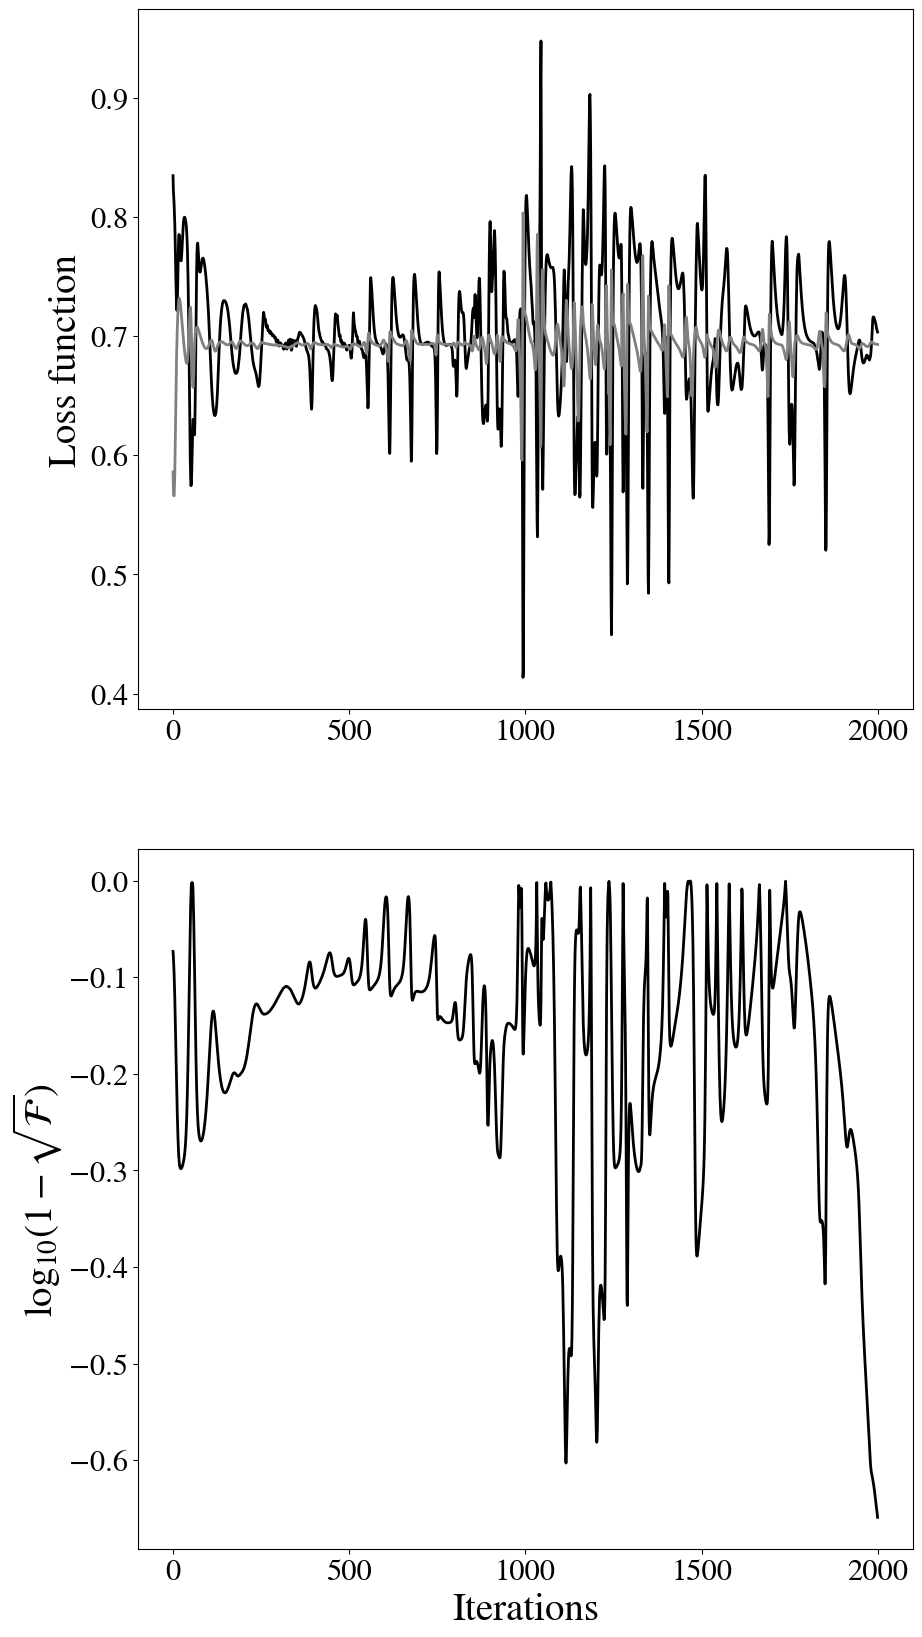

In [14]:
fig = plt.figure(figsize=np.array(figsize)*[1,2])
ax = fig.add_subplot(211)

plt.plot(generator_loss_values, lw=2, color='black')
plt.plot(discriminator_loss_values, lw=2, color='grey')
ax.set_ylabel('Loss function', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax = fig.add_subplot(212)

plt.plot(np.log10(entropy_values), lw=2, color='black')
ax.set_ylabel(r'log$_{10}(1-\sqrt{\mathcal{F}})$', fontsize=fontsize);
ax.set_xlabel('Iterations', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

In [15]:
with torch.no_grad():
    generated_weights = generator.weight.detach().numpy().reshape((reps+1,n))

In [16]:
circ = QuantumCircuit(n)
circ.h(circ.qubits)

for rep in np.arange(reps+1):
    for i in np.arange(n):
        circ.ry(generated_weights[rep,i],circ.qubits[i])
    for i in np.arange(n):
        if i!=n-1 and rep!=reps:
            circ.cx(circ.qubits[i], circ.qubits[i+1])

backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

fidelity = np.abs(np.dot(np.sqrt(prob_data),np.conjugate(state_vector)))**2

mismatch = 1. - np.sqrt(fidelity)

print('Fidelity:', fidelity, 'Mismatch:', mismatch)

Fidelity: 0.6095930945194972 Mismatch: 0.21923557040583797


In [17]:
def amplitude(nqubit):
    xs = np.linspace(xmin, xmax, 2**nqubit)
    amps = xs**(-7./6)
    norm = np.sqrt(np.sum(np.abs(amps)**2))
    return amps/norm

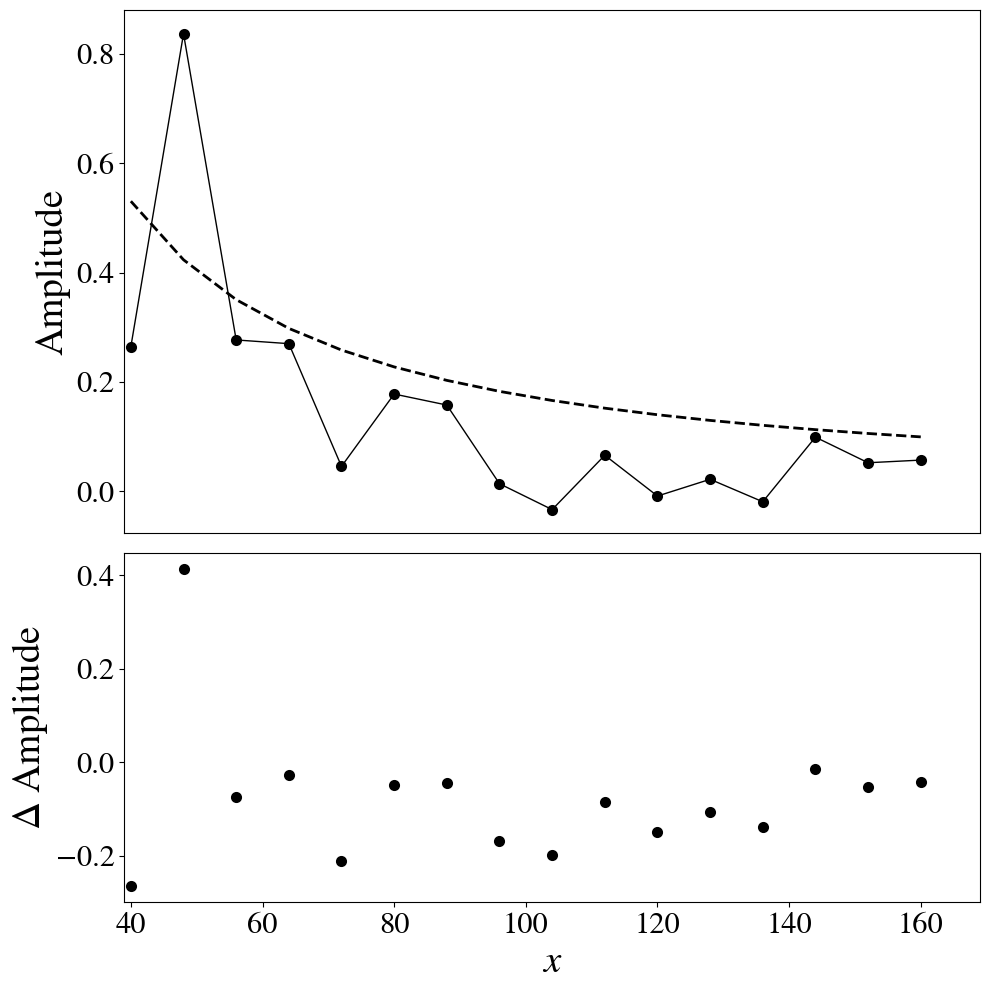

In [18]:
target_state = amplitude(nx)

fig, ax = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [1.5, 1]})

color1 = 'black'
color2 = 'grey'

ax[0].scatter(xs, state_vector.real, color=color1, lw=2)
ax[0].plot(xs, state_vector.real, color=color1, ls='-', lw=1)
ax[0].plot(xs, target_state, color=color1, ls='--', lw=2)

ax[0].tick_params(axis='both', labelsize=ticksize)
ax[1].set_xlabel(r'$x$', fontsize=fontsize)
ax[0].set_ylabel(r'Amplitude', fontsize=fontsize)
ax[0].set_xlim(xmin-1,xmax+1)

ax[0].set_xticks([])

ax[1].scatter(xs, state_vector.real-target_state.real, color=color1, lw=2)
ax[1].set_ylabel(r'$\Delta$ Amplitude', fontsize=fontsize)
ax[1].tick_params(axis='both', labelsize=ticksize)
ax[1].set_xlim(xmin-1,xmax+1)

fig.tight_layout()

plt.show()